# K-means clustering algorithm for PSDs families

---

## Imports

In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import seaborn as sns
from dask import delayed, compute
import itertools
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
import matplotlib.transforms as mtransforms
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import matplotlib.pylab as pl
from dask import delayed, compute
import warnings
warnings.filterwarnings('ignore')


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

In [3]:
cluster = LocalCluster()  
cluster

## Data

In [4]:
aircraft = 'Lear'
aircraft2 = 'Learjet'
aircraft1 = 'P3B'
aircraft3 = 'P3B'

In [5]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear_corr_merged.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store11 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B_corr_merged.zarr"
store

'/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/zarr/dm_retrieved_Lear_corr_merged.zarr'

In [6]:
dm_lear = xr.open_zarr(store)
dm_p3b = xr.open_zarr(store3)
ds_lear = xr.open_zarr(store1)
ds_lear['altitude'] = ds_lear['altitude'] * 0.3046
ds_lear = ds_lear.drop_sel(time='2019-09-09 00:54:08')
ds_p3b = xr.open_zarr(store2)

In [7]:
ds_new_lear = xr.merge([dm_lear, ds_lear], compat='override')
ds_new_p3b = xr.merge([dm_p3b, ds_p3b], compat='override')

In [8]:
new_cols = ['dbz_t_ka', 'dbz_t_ku', 'Att_ku', "Att_ka", 'nt', 'lwc_cum', 'mu', 'new_mu', 'mu3', 'mu_bf','sigma', 'sigmap', 'dm', 
            'log10_nw', 'r', 'dfr', 'temp', 'vert_vel', 'altitude','z_ku_mu1', 'z_ku_mu2', 'z_ku_mu3', 'z_ku_mu_bf',
            'z_ka_mu1', 'z_ka_mu2', 'z_ka_mu3', 'z_ka_mu_bf', 'lon', 'lat', 'r', 'r_dm_gm_mu_3', 'r_gpm_operational', 'r_true_nw_mu_dm', 
           'dm_rt_dfr_gm_mu_3', 'dm_rt_dfr_nd_mu_3', 'log10nw_dm_gm_mu_3']

In [9]:
dm_l = ds_new_lear[new_cols]
dm_p = ds_new_p3b[new_cols]
ds = xr.concat([dm_l, dm_p], dim='time')
ds = ds.where(ds.lwc_cum > 0.01, drop=True)

In [10]:
ds_cluster = ds
ds_cluster['logr'] = np.log10(ds.r)
ds_cluster['lognt'] = np.log10(ds.nt)
ds_cluster['loglwc'] = np.log10(ds.lwc_cum)

In [11]:
df = ds_cluster.to_dataframe().reset_index()
df.shape

(8710, 39)

In [12]:
scaler = StandardScaler()
df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

## K-means clustering benchmarking

In [13]:
def get_kmeans_score(df, center):
    '''
    returns the elbow inertial index, the Davies Bouldin and Silhouette score
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        elbow inertial index, the Davies Bouldin and Silhouette score
    '''
    kmeans = KMeans(n_clusters=center, random_state=10)
    model = kmeans.fit(df)
    model2 = kmeans.fit_predict(df)
    cluster_labels = model.labels_
    
    dav = davies_bouldin_score(df, model2)
    sil = silhouette_score(df, cluster_labels)
    elbow = model.inertia_
    return dav, sil, elbow



In [14]:
dav = []
sil = []
elbow = []

In [15]:
# for k in range(2,15):
#     _dav, _sil, _el = get_kmeans_score(df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]], k)
#     dav.append(_dav)
#     sil.append(_sil)
#     elbow.append(_el)

In [16]:
# centers = range(2,15)
# fig, (ax, ax1) = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
# ax.plot(centers, elbow, linestyle='--', marker='o', color='b');
# ax.set_xlabel('K');
# ax.set_ylabel('Score');
# ax1.plot(centers[1:], np.array(elbow[:-1]) - np.array(elbow[1:]) , linestyle='--', marker='o', color='r');
# # ax1.bar(centers[1:], height=np.array(elbow[:-1]) - np.array(elbow[1:]));

# ax1.set_xlabel('K');
# ax1.set_ylabel('Rate of change');
# plt.tight_layout()

In [17]:
# centers = range(2,15)
# fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
# ax.plot(centers, dav, linestyle='--', marker='o', color='b');
# ax.set_xlabel('K');
# ax.set_ylabel('Score');
# ax.set_title('Davies Bouldin method');

# ax1.plot(centers, sil, linestyle='--', marker='o', color='b');
# ax1.set_xlabel('K');
# ax1.set_ylabel('Score');
# ax1.set_title('silhouette method');

# ax2.plot(centers, elbow, linestyle='--', marker='o', color='b');
# ax2.set_xlabel('K');
# ax2.set_ylabel('Score');
# ax2.set_title('Elbow method');
# fig.tight_layout()

## K-means clustering with 6 PSD families

In [18]:
n_c = np.arange(1, 7)
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]
kmeans = KMeans(n_clusters=6, random_state=10)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=10)

In [19]:
centroids2  = scaler.inverse_transform(kmeans.cluster_centers_)

In [20]:
df['kmeans_6'] = kmeans.labels_ + 1

In [21]:
df['kmeans'] = df['kmeans_6'].replace([1, 2, 3, 4, 5, 6], [5,3,4,1,2,6])
df['dfr'] = df['dbz_t_ku'] - df['dbz_t_ka']
df['dm_class'] = (df.dm > 1.0).astype(int)
df.shape

(8710, 48)

In [22]:
df.to_csv('../results/df_cluster.csv')

In [23]:
df.to_parquet('/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/parquet/df_cluster.parquet')

In [24]:
from matplotlib.colors import ListedColormap
my_cmap6 = ListedColormap(sns.color_palette('deep', 6))
colors6 = my_cmap6(np.linspace(0,1,6))

In [25]:
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

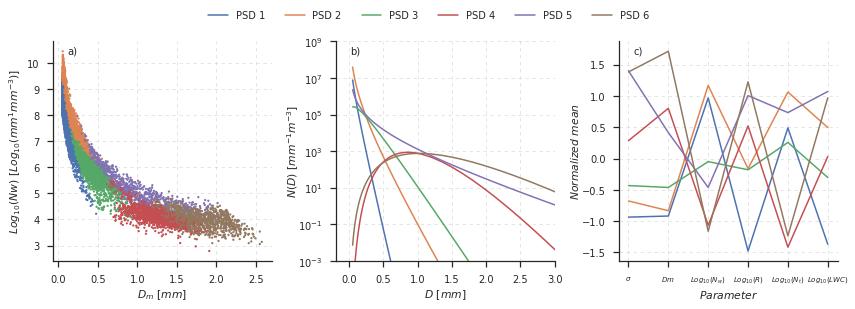

In [26]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(12,4))
ax = axs['a)']
# sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_6'], s=1.5, cmap=my_cmap6)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

ax1 = axs['b)']
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_xlim(-0.2, 3)
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")

for i in n_c:
    df_sub = df[df['kmeans_6'] == i]
    df_sub = df[df['kmeans'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i-1], label=f"PSD {i}")
    
ax2 = axs['c)']
# ax2.set_yscale('log
# ax2 = sns.boxenplot(data=df, x="kmeans_6", y="r",ax=ax2)
# ax2.set_ylabel('$Rainfall \ Rate \ [mmhr^{-1}]$')
# ax2.set_xlabel('$PSD$')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

df_nm = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]].groupby(df['kmeans_6']).mean().T
df_nm = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]].groupby(df['kmeans']).mean().T
df_nm.plot(ax=ax2, legend=False, label=None)
ax2.set_ylabel("$Normalized \ mean$", labelpad=1)
ax2.set_xticklabels(["", '$\sigma$', '$Dm$', '$Log_{10}(N_w)$', '$Log_{10}(R)$', "$Log_{10}(N_t)$", "$Log_{10}(LWC)$", ""], size=7)
ax2.set_xlabel("$Parameter$")
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(15/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')


fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=[0.5, 1.08])
fig.tight_layout()
sns.despine()

In [27]:
axs

{'a)': <Axes: label='a)', xlabel='$D_m \\ [mm]$', ylabel='$Log_{10}(Nw) \\ [Log_{10}(mm^{1}mm^{-3})]$'>,
 'b)': <Axes: label='b)', xlabel='$D\\ [mm]$', ylabel='$N(D) \\  [mm^{-1}m^{-3}]$'>,
 'c)': <Axes: label='c)', xlabel='$Parameter$', ylabel='$Normalized \\ mean$'>}

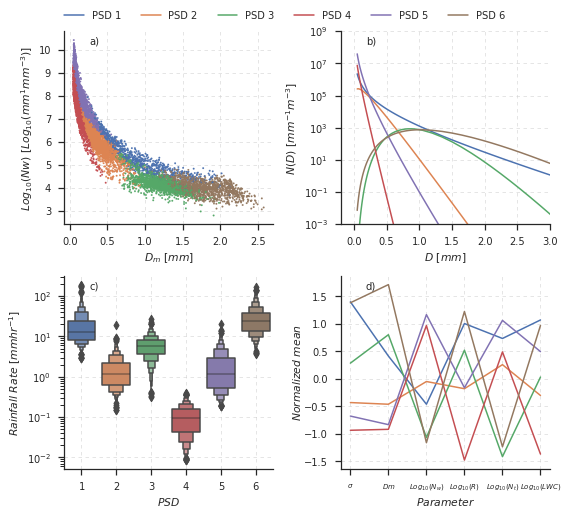

In [28]:
# fig, ax = plt.subplots(2, 2, figsize=(8,7))
fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'd)']], figsize=(8,7))

ax = axs['a)']
ax = sns.scatterplot(data=df, x=df['dm'], y=df['log10_nw'], hue=df['kmeans_6'], s=3, ax=ax, 
                          palette=sns.color_palette('deep', 6), legend=False, edgecolor=None)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

ax1 = axs['b)']
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both')
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$")
ax1.set_xlabel("$D\ [mm]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_xlim(-0.2, 3)

for i in n_c:
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i-1], label=f"PSD {i}")
ax2 = axs['c)']
ax2.set_yscale('log')
ax2 = sns.boxenplot(data=df, x="kmeans_6", y="r",ax=ax2)
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.set_ylabel('$Rainfall \ Rate \ [mmhr^{-1}]$')
ax2.set_xlabel('$PSD$')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax3 = axs['d)']

df_nm = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]].groupby(df['kmeans_6']).mean().T
df_nm.plot(ax=ax3, legend=False)
ax3.set_ylabel("$Normalized \ mean$", labelpad=1)
ax3.set_xticklabels(["", '$\sigma$', '$Dm$', '$Log_{10}(N_w)$', '$Log_{10}(R)$', "$Log_{10}(N_t)$", "$Log_{10}(LWC)$", ""], size=7)
ax3.set_xlabel("$Parameter$")
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
sns.despine()

fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=[0.5, 1.025])
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(25/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
plt.savefig("../results/kmeans.svg", bbox_inches='tight')

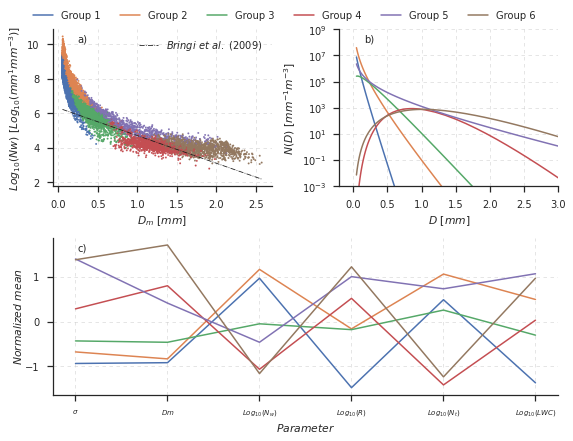

In [29]:
# fig, ax = plt.subplots(2, 2, figsize=(8,7))
fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'c)']], figsize=(8,6))

ax = axs['a)']
# ax = sns.scatterplot(data=df, x=df['dm'], y=df['log10_nw'], hue=df['kmeans_6'], s=3, ax=ax, 
ax = sns.scatterplot(data=df, x=df['dm'], y=df['log10_nw'], hue=df['kmeans'], s=3, ax=ax, 
                          palette=sns.color_palette('deep', 6), legend=False, edgecolor=None)

ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

dms = np.linspace(df['dm'].min(), df['dm'].max(), 100)
s_c = -1.6 * dms + 6.3
ax.plot(dms, s_c, c='k', ls='-.', lw=0.8, label=r"$Bringi \ et \ al. \ (2009)$")
# ax.hlines(y=3.85, xmin=dms.min(), xmax=dms.max(), colors='k', linestyles='--', lw=0.8, label=r"$Thompson \ et \  al. \ (2015)$")
ax.legend()


ax1 = axs['b)']
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both')
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$")
ax1.set_xlabel("$D\ [mm]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_xlim(-0.2, 3)

for i in n_c:
    df_sub = df[df['kmeans'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i-1], label=f"Group {i}")
# ax2 = axs['c)']
# ax2.set_yscale('log')
# ax2 = sns.boxenplot(data=df, x="kmeans_6", y="r",ax=ax2)
# ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax2.set_ylabel('$Rainfall \ Rate \ [mmhr^{-1}]$')
# ax2.set_xlabel('$PSD$')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax3 = axs['c)']

df_nm = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]].groupby(df['kmeans']).mean().T
df_nm.plot(ax=ax3, legend=False)
ax3.set_ylabel("$Normalized \ mean$", labelpad=1)
ax3.set_xticklabels(["", '$\sigma$', '$Dm$', '$Log_{10}(N_w)$', '$Log_{10}(R)$', "$Log_{10}(N_t)$", "$Log_{10}(LWC)$", ""], size=7)
ax3.set_xlabel("$Parameter$")
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
sns.despine()

fig.legend(lines[1:], labels[1:], loc='upper center', ncol=6, bbox_to_anchor=[0.5, 1.025])
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(25/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
plt.savefig("../results/kmeans2.svg", bbox_inches='tight')

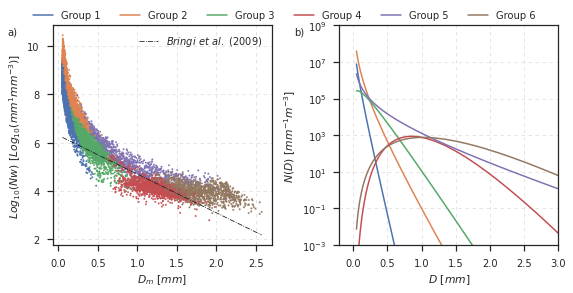

In [39]:
# fig, ax = plt.subplots(2, 2, figsize=(8,7))
fig, axs = plt.subplot_mosaic([['a)', 'b)']], figsize=(8,4))

ax = axs['a)']
# ax = sns.scatterplot(data=df, x=df['dm'], y=df['log10_nw'], hue=df['kmeans_6'], s=3, ax=ax, 
ax = sns.scatterplot(data=df, x=df['dm'], y=df['log10_nw'], hue=df['kmeans'], s=3, ax=ax, 
                          palette=sns.color_palette('deep', 6), legend=False, edgecolor=None)

ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

dms = np.linspace(df['dm'].min(), df['dm'].max(), 100)
s_c = -1.6 * dms + 6.3
ax.plot(dms, s_c, c='k', ls='-.', lw=0.8, label=r"$Bringi \ et \ al. \ (2009)$")
# ax.hlines(y=3.85, xmin=dms.min(), xmax=dms.max(), colors='k', linestyles='--', lw=0.8, label=r"$Thompson \ et \  al. \ (2015)$")
ax.legend()


ax1 = axs['b)']
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both')
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$")
ax1.set_xlabel("$D\ [mm]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_xlim(-0.2, 3)

for i in n_c:
    df_sub = df[df['kmeans'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i-1], label=f"Group {i}")
# ax2 = axs['c)']
# ax2.set_yscale('log')
# ax2 = sns.boxenplot(data=df, x="kmeans_6", y="r",ax=ax2)
# ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax2.set_ylabel('$Rainfall \ Rate \ [mmhr^{-1}]$')
# ax2.set_xlabel('$PSD$')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# ax3 = axs['c)']

# df_nm = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]].groupby(df['kmeans']).mean().T
# df_nm.plot(ax=ax3, legend=False)
# ax3.set_ylabel("$Normalized \ mean$", labelpad=1)
# ax3.set_xticklabels(["", '$\sigma$', '$Dm$', '$Log_{10}(N_w)$', '$Log_{10}(R)$', "$Log_{10}(N_t)$", "$Log_{10}(LWC)$", ""], size=7)
# ax3.set_xlabel("$Parameter$")
# ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# sns.despine()

fig.legend(lines[1:], labels[1:], loc='upper center', ncol=6, bbox_to_anchor=[0.5, 1.025])
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-45/72, -1/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
plt.savefig("../results/kmeans3.svg", bbox_inches='tight')

In [31]:
df_results = df[[ 'dm', 'log10_nw', 'new_mu','sigma','r', 'lognt', 'lwc_cum', 'vert_vel', 'kmeans']].groupby('kmeans').quantile(0.5)

In [32]:
df_results.to_csv('../results/kmeans_params.csv', sep=',')

In [33]:
df_results

,dm,log10_nw,new_mu,sigma,r,lognt,lwc_cum,vert_vel
kmeans,,,,,,,,
1,0.077694,8.041718,-1.856160,0.054354,0.095984,5.765579,0.061125,0.0
2,0.129001,8.131595,-1.481057,0.106959,1.196485,6.540087,0.586893,0.1
3,0.366003,6.017403,0.264269,0.170222,1.203541,5.528031,0.221926,-0.1
4,1.207396,4.118460,5.008164,0.334636,5.732966,2.768183,0.353885,-0.1
5,0.900394,5.154574,1.284660,0.588316,13.100539,6.175472,1.245962,0.5
6,1.751335,3.992222,2.596270,0.581351,23.475568,2.941859,1.144591,-0.3
